In [11]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import functions as fun

In [12]:
mods = fun.models()

In [13]:
mpl.rcParams['xtick.labelsize']       = 9
mpl.rcParams['ytick.labelsize']       = 9
mpl.rcParams['lines.linewidth']       = 2.
mpl.rcParams['axes.labelsize']        = 9
#mpl.rcParams['axes.labelweight']      = 'bold'
mpl.rcParams['axes.titlesize']        = 9
mpl.rcParams['font.family']           = 'serif'
#mpl.rcParams['axes.titleweight']      = 'bold'
mpl.rcParams['figure.subplot.bottom'] = .2
mpl.rcParams['figure.subplot.top']    = .9
mpl.rcParams['figure.subplot.left']   = .05
mpl.rcParams['figure.subplot.right']  = .99
mpl.rcParams['figure.subplot.wspace'] = .02
mpl.rcParams['figure.subplot.hspace'] = .0
mpl.rcParams['figure.figsize']        = 7,3.5


cols = {}
cols['ocean'] = '.7'
cols['land'] = '.9'

In [14]:
#Get 1x1 degree grid
with xr.open_dataset('data/rsl_85_2090.nc') as ds:
    lon = ds['x'].values
    lat = ds['y'].values
    slr_md = ds['slr_md'].values

#Get fingerprints
with xr.open_dataset('data/fp_uniform/AIS.nc') as ds:
    lon05  = ds['x'].values
    lat05  = ds['y'].values
    fp05_a = ds['rsl'].values
with xr.open_dataset('data/fp_uniform/GrIS.nc') as ds:
    fp05_gr = ds['rsl'].values
fp05_gl = np.zeros((19,len(lat05),len(lon05)))
for r in range(1,20):
    with xr.open_dataset(f'data/fp_uniform/RGI_{r}.nc') as ds:
        fp05_gl[r-1,:,:] = ds['rsl'].values

#Convert to 1x1 degree grid
fp_a  = np.zeros((len(lat),len(lon)))
fp_gr = np.zeros((len(lat),len(lon)))
fp_gl = np.zeros((19,len(lat),len(lon)))

for i,ii in enumerate(lat):
    ig = np.argmin((ii-lat05)**2)
    for j,jj in enumerate(lon):
        jg = np.argmin((jj-lon05)**2)
        fp_a[i,j] = fp05_a[ig,jg]
        fp_gr[i,j] = fp05_gr[ig,jg]
        fp_gl[:,i,j] = fp05_gl[:,ig,jg]

In [15]:
def get_mms(scen):
    with xr.open_dataset(f'data/rsl/{mods[0]}_{scen}.nc') as ds:
        lon = ds['lon'].values
        lat = ds['lat'].values
    mm = np.zeros((len(mods),len(lat),len(lon)))

    for m,model in enumerate(mods):
        with xr.open_dataset(f'data/rsl/{model}_{scen}.nc') as ds:
            zos  = np.nanmean(ds['ocean'][-20:,:,:].values,axis=0)
            ster = np.nanmean(ds['steric'][-20:,:,:].values,axis=0)
            adyn = np.nanmean(ds['antdyn'][-20:,:,:].values,axis=0)
            asmb = np.nanmean(ds['antsmb'][-20:,:,:].values,axis=0)
            gsmb = np.nanmean(ds['grsmb'][-20:,:,:].values,axis=0)
            glac = np.nanmean(ds['glacier'][-20:,:,:].values,axis=0)
            
            mm[m,:,:] = zos+ster+adyn+asmb+gsmb+glac

    mms = np.nanvar(mm,axis=0)
    mms[np.isnan(slr_md)]=np.nan
    return mms

In [16]:
def sig(var):
    return np.std(var,axis=0)

In [17]:
def get_srocc(scen):
    srocc = np.zeros((len(mods),len(lat),len(lon)))
    zos = np.zeros((len(mods),len(lat),len(lon)))
    ster = np.zeros((len(mods),len(lat),len(lon)))
    stdn = np.zeros((len(mods),len(lat),len(lon)))
    adyn = np.zeros((len(mods),len(lat),len(lon)))
    asmb = np.zeros((len(mods),len(lat),len(lon)))
    gsmb = np.zeros((len(mods),len(lat),len(lon)))
    glac = np.zeros((len(mods),len(lat),len(lon)))

    for m,model in enumerate(mods):

        #Get zos
        file = f'data/zos/CorrectedZOS_EXP{scen}_{model}.nc'
        with xr.open_dataset(file) as ds:
            zos[m,:,:] = np.nanmean(ds['CorrectedZOS_reg'][-20:,:,:].values,axis=0)

        #Add steric expansion    
        with xr.open_dataset(f'data/steric/{model}_{scen}.nc') as ds:
            ster[m,:,:] = np.nanmean(ds['SLR'][-20:].values)
        stdn[m,:,:] = zos[m,:,:]+ster[m,:,:]
            
        #Add Antarctic dyn
        with xr.open_dataset(f'data/Adyn/{model}_{scen}.nc') as ds:
            adyn[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a

        #Add Antarctic smb
        with xr.open_dataset(f'data/Asmb/{model}_{scen}.nc') as ds:
            asmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_a     

        #Add Greenland smb
        with xr.open_dataset(f'data/Gsmb/{model}_{scen}.nc') as ds:  
            gsmb[m,:,:] = np.nanmean(ds['SLR'][-20:].values)*fp_gr

        #Add glaciers
        for r in range(1,20):
            with xr.open_dataset(f'data/glacier/{model}_{scen}_{r}.nc') as ds:
                glac[m,:,:] += np.nanmean(ds['SLR'][-20:].values)*fp_gl[r-1,:,:]
        
    srocc = ((sig(stdn)+sig(asmb)+sig(gsmb))**2+sig(glac)**2+sig(adyn)**2)
    srocc[np.isnan(slr_md)]=np.nan
    return srocc

In [18]:
def makeglobal(ax):
    ax.set_global()
    ax.add_feature(cfeature.LAND,color=cols['land'])
    ax.add_feature(cfeature.OCEAN,color=cols['ocean'])
    ax.outline_patch.set_visible(False)

In [19]:
mms = {}
srocc = {}
for scen in ['rcp45','rcp85']:
    mms[scen] = get_mms(scen)
    srocc[scen] = get_srocc(scen)

/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/erwin/miniconda2/envs/codep/lib/python3.6/site-packages/ip

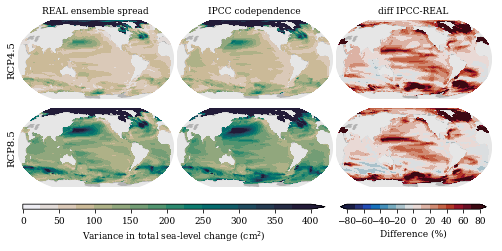

In [24]:
fig = plt.figure()

cmap1 = plt.get_cmap('cmo.speed',16)
cmap1 = plt.get_cmap('cmo.rain',16)
cmap2 = plt.get_cmap('cmo.balance',16)
slab = ['RCP4.5','RCP8.5']

for s,scen in enumerate(['rcp45','rcp85']):
    mm = mms[scen]
    sr = srocc[scen]
    
    ax = fig.add_subplot(2,3,1+3*s,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,mm,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)
    makeglobal(ax)
    if s==0: ax.set_title('REAL ensemble spread')
    ax.text(-.01,.5,slab[s],transform=ax.transAxes,rotation='vertical',va='bottom',ha='center',rotation_mode='anchor')
    
    ax = fig.add_subplot(2,3,2+3*s,projection=ccrs.Robinson(central_longitude=200))
    im = ax.pcolormesh(lon,lat,sr,transform=ccrs.PlateCarree(),vmin=0,vmax=400,cmap=cmap1)
    makeglobal(ax)
    if s==0: ax.set_title('IPCC codependence')

    ax = fig.add_subplot(2,3,3+3*s,projection=ccrs.Robinson(central_longitude=200))
    im2 = ax.pcolormesh(lon,lat,100.*(sr-mm)/mm,transform=ccrs.PlateCarree(),vmin=-80,vmax=80,cmap=cmap2)
    makeglobal(ax)
    if s==0: ax.set_title('diff IPCC-REAL')


cax = fig.add_axes([.06,.13,.6,.02])
cb = plt.colorbar(im,cax=cax,extend='max',orientation='horizontal')
cb.set_label('Variance in total sea-level change (cm$^2$)')

cax = fig.add_axes([.69,.13,.29,.02])
cb = plt.colorbar(im2,cax=cax,extend='both',orientation='horizontal')
cb.set_label('Difference (%)')

figname = 'draftplot_regvar.png'

plt.savefig(f'figures/{figname}',dpi=200)
plt.savefig(f'../../writing/codependence/figures/{figname}')
plt.show()
plt.close()